In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt


In [2]:
class BSDS500Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.image_files = [os.path.join(root_dir, 'images', split, f) for f in os.listdir(os.path.join(root_dir, 'images', split))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)

        return image


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((33, 33))
])

root_dir = "BSR/BSDS500/data"
train_dataset = BSDS500Dataset(root_dir=root_dir, split='train', transform=transform)
val_dataset = BSDS500Dataset(root_dir=root_dir, split='val', transform=transform)
test_dataset = BSDS500Dataset(root_dir=root_dir, split='test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [4]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

model = SRCNN().to('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
def calculate_metrics(output, target):
    output_np = output.permute(0, 2, 3, 1).cpu().numpy()
    target_np = target.permute(0, 2, 3, 1).cpu().numpy()
    ssim_val = np.mean([ssim(o, t, data_range=t.max() - t.min(), channel_axis=-1, win_size=5) for o, t in zip(output_np, target_np)])
    psnr_val = np.mean([psnr(t, o, data_range=t.max() - t.min()) for o, t in zip(output_np, target_np)])
    mse_val = np.mean((output_np - target_np) ** 2)
    return ssim_val, psnr_val, mse_val


In [12]:
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epoch in range(num_epochs):
    model.train()
    for i, data in enumerate(train_loader):
        inputs = data.to(device)
        inputs_upsampled = F.interpolate(inputs, scale_factor=2, mode='bicubic', align_corners=False)
        outputs = model(inputs_upsampled)
        loss = criterion(outputs, inputs_upsampled)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Validation
    model.eval()
    ssim_total, psnr_total, mse_total = 0, 0, 0
    with torch.no_grad():
        for data in val_loader:
            inputs = data.to(device)
            inputs_upsampled = F.interpolate(inputs, scale_factor=2, mode='bicubic', align_corners=False)
            outputs = model(inputs_upsampled)
            ssim_val, psnr_val, mse_val = calculate_metrics(outputs, inputs_upsampled)
            ssim_total += ssim_val
            psnr_total += psnr_val
            mse_total += mse_val

    print(f'Validation - Epoch [{epoch+1}/{num_epochs}], SSIM: {ssim_total/len(val_loader):.4f}, PSNR: {psnr_total/len(val_loader):.4f}, MSE: {mse_total/len(val_loader):.4f}')


Epoch [1/100], Step [10/13], Loss: 0.0015
Validation - Epoch [1/100], SSIM: 0.8886, PSNR: 27.8722, MSE: 0.0013
Epoch [2/100], Step [10/13], Loss: 0.0011
Validation - Epoch [2/100], SSIM: 0.8955, PSNR: 28.6644, MSE: 0.0011
Epoch [3/100], Step [10/13], Loss: 0.0011
Validation - Epoch [3/100], SSIM: 0.9023, PSNR: 29.1528, MSE: 0.0010
Epoch [4/100], Step [10/13], Loss: 0.0008
Validation - Epoch [4/100], SSIM: 0.9086, PSNR: 29.6396, MSE: 0.0009
Epoch [5/100], Step [10/13], Loss: 0.0010
Validation - Epoch [5/100], SSIM: 0.9146, PSNR: 29.8720, MSE: 0.0008
Epoch [6/100], Step [10/13], Loss: 0.0007
Validation - Epoch [6/100], SSIM: 0.9185, PSNR: 30.2915, MSE: 0.0007
Epoch [7/100], Step [10/13], Loss: 0.0008
Validation - Epoch [7/100], SSIM: 0.9227, PSNR: 30.3291, MSE: 0.0007
Epoch [8/100], Step [10/13], Loss: 0.0007
Validation - Epoch [8/100], SSIM: 0.9273, PSNR: 30.4422, MSE: 0.0007
Epoch [9/100], Step [10/13], Loss: 0.0007
Validation - Epoch [9/100], SSIM: 0.9310, PSNR: 31.1710, MSE: 0.0006
E

In [13]:
def evaluate(model, dataloader):
    model.eval()
    ssim_total, psnr_total, mse_total = 0, 0, 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data.to(device)
            inputs_upsampled = F.interpolate(inputs, scale_factor=2, mode='bicubic', align_corners=False)
            outputs = model(inputs_upsampled)
            ssim_val, psnr_val, mse_val = calculate_metrics(outputs, inputs_upsampled)
            ssim_total += ssim_val
            psnr_total += psnr_val
            mse_total += mse_val

    print(f'Test - SSIM: {ssim_total/len(dataloader):.4f}, PSNR: {psnr_total/len(dataloader):.4f}, MSE: {mse_total/len(dataloader):.4f}')

evaluate(model, test_loader)


Test - SSIM: 0.9777, PSNR: 37.8323, MSE: 0.0002


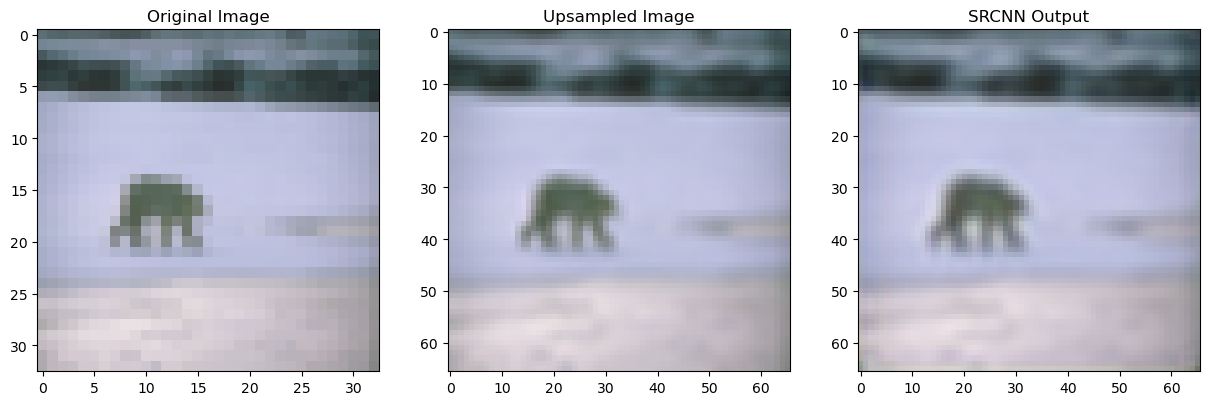

In [14]:
def visualize_results(model, dataloader):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs = data.to(device)
            inputs_upsampled = F.interpolate(inputs, scale_factor=2, mode='bicubic', align_corners=False)
            outputs = model(inputs_upsampled)

            # Display the input, upsampled, and output images
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(inputs[0].cpu().permute(1, 2, 0))
            axs[0].set_title('Original Image')
            axs[1].imshow(inputs_upsampled[0].cpu().permute(1, 2, 0))
            axs[1].set_title('Upsampled Image')
            axs[2].imshow(outputs[0].cpu().permute(1, 2, 0))
            axs[2].set_title('SRCNN Output')
            plt.show()

            # Only visualize one batch for simplicity
            break

visualize_results(model, test_loader)


In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt


In [2]:
class BSDS500Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.image_files = [os.path.join(root_dir, 'images', split, f) for f in os.listdir(os.path.join(root_dir, 'images', split))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)

        return image


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128))  # Set to a higher resolution
])

root_dir = "BSR/BSDS500/data"
train_dataset = BSDS500Dataset(root_dir=root_dir, split='train', transform=transform)
val_dataset = BSDS500Dataset(root_dir=root_dir, split='val', transform=transform)
test_dataset = BSDS500Dataset(root_dir=root_dir, split='test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) #  load data in batches 
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [4]:
class SRCNN(nn.Module): # neural network module 
    def __init__(self):
        super(SRCNN, self).__init__() # calls the constructor of the parent class (nn.Module) # it ensures that the nn.Module part of the SRCNN object is properly set up.
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

model = SRCNN().to('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [7]:
def calculate_metrics(output, target):
    output_np = output.permute(0, 2, 3, 1).cpu().numpy() #  Changes the order of dimensions of the tensor. If the original shape is (batch_size, channels, height, width), it changes it to (batch_size, height, width, channels).
    target_np = target.permute(0, 2, 3, 1).cpu().numpy()
    ssim_val = np.mean([ssim(o, t, data_range=t.max() - t.min(), channel_axis=-1, win_size=5) for o, t in zip(output_np, target_np)])
    psnr_val = np.mean([psnr(t, o, data_range=t.max() - t.min()) for o, t in zip(output_np, target_np)])
    mse_val = np.mean((output_np - target_np) ** 2)
    return ssim_val, psnr_val, mse_val


Epoch [1/100], Step [10/13], Loss: 0.0386
Validation - Epoch [1/100], SSIM: 0.3517, PSNR: 14.7911, MSE: 0.0298
Epoch [2/100], Step [10/13], Loss: 0.0220
Validation - Epoch [2/100], SSIM: 0.3750, PSNR: 16.4135, MSE: 0.0203
Epoch [3/100], Step [10/13], Loss: 0.0137
Validation - Epoch [3/100], SSIM: 0.4164, PSNR: 17.7000, MSE: 0.0152
Epoch [4/100], Step [10/13], Loss: 0.0119
Validation - Epoch [4/100], SSIM: 0.4684, PSNR: 19.3868, MSE: 0.0104
Epoch [5/100], Step [10/13], Loss: 0.0079
Validation - Epoch [5/100], SSIM: 0.5119, PSNR: 20.6517, MSE: 0.0078
Epoch [6/100], Step [10/13], Loss: 0.0061
Validation - Epoch [6/100], SSIM: 0.5448, PSNR: 21.5033, MSE: 0.0065
Epoch [7/100], Step [10/13], Loss: 0.0047
Validation - Epoch [7/100], SSIM: 0.5676, PSNR: 21.9505, MSE: 0.0058
Epoch [8/100], Step [10/13], Loss: 0.0063
Validation - Epoch [8/100], SSIM: 0.5891, PSNR: 22.2164, MSE: 0.0055
Epoch [9/100], Step [10/13], Loss: 0.0049
Validation - Epoch [9/100], SSIM: 0.6051, PSNR: 22.6006, MSE: 0.0050
E

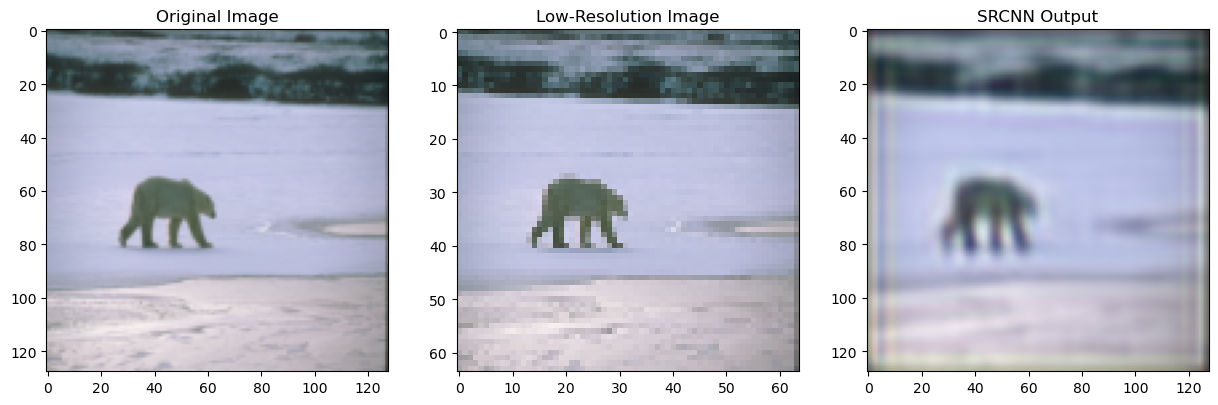

Epoch [11/100], Step [10/13], Loss: 0.0038
Validation - Epoch [11/100], SSIM: 0.6415, PSNR: 23.5217, MSE: 0.0041
Epoch [12/100], Step [10/13], Loss: 0.0038
Validation - Epoch [12/100], SSIM: 0.6554, PSNR: 23.7152, MSE: 0.0040
Epoch [13/100], Step [10/13], Loss: 0.0040
Validation - Epoch [13/100], SSIM: 0.6724, PSNR: 24.1234, MSE: 0.0036
Epoch [14/100], Step [10/13], Loss: 0.0030
Validation - Epoch [14/100], SSIM: 0.6850, PSNR: 24.2860, MSE: 0.0035
Epoch [15/100], Step [10/13], Loss: 0.0044
Validation - Epoch [15/100], SSIM: 0.6963, PSNR: 24.4649, MSE: 0.0034
Epoch [16/100], Step [10/13], Loss: 0.0035
Validation - Epoch [16/100], SSIM: 0.7075, PSNR: 24.7729, MSE: 0.0032
Epoch [17/100], Step [10/13], Loss: 0.0035
Validation - Epoch [17/100], SSIM: 0.7165, PSNR: 24.9459, MSE: 0.0030
Epoch [18/100], Step [10/13], Loss: 0.0032
Validation - Epoch [18/100], SSIM: 0.7244, PSNR: 25.0871, MSE: 0.0029
Epoch [19/100], Step [10/13], Loss: 0.0022
Validation - Epoch [19/100], SSIM: 0.7313, PSNR: 25.0

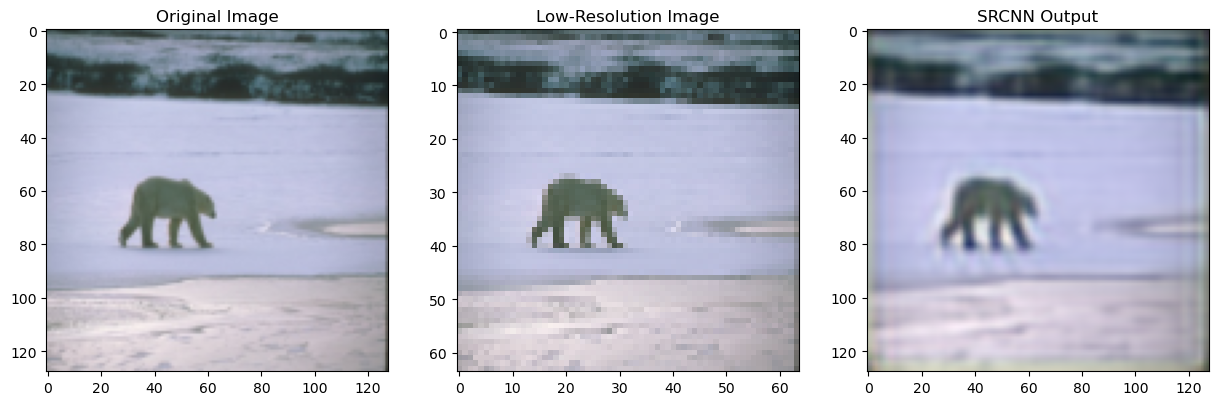

Epoch [21/100], Step [10/13], Loss: 0.0027
Validation - Epoch [21/100], SSIM: 0.7459, PSNR: 25.0619, MSE: 0.0029
Epoch [22/100], Step [10/13], Loss: 0.0037
Validation - Epoch [22/100], SSIM: 0.7547, PSNR: 25.7445, MSE: 0.0025
Epoch [23/100], Step [10/13], Loss: 0.0019
Validation - Epoch [23/100], SSIM: 0.7595, PSNR: 25.4631, MSE: 0.0026
Epoch [24/100], Step [10/13], Loss: 0.0026
Validation - Epoch [24/100], SSIM: 0.7648, PSNR: 25.6055, MSE: 0.0026
Epoch [25/100], Step [10/13], Loss: 0.0030
Validation - Epoch [25/100], SSIM: 0.7706, PSNR: 25.7938, MSE: 0.0025
Epoch [26/100], Step [10/13], Loss: 0.0017
Validation - Epoch [26/100], SSIM: 0.7748, PSNR: 25.9882, MSE: 0.0024
Epoch [27/100], Step [10/13], Loss: 0.0022
Validation - Epoch [27/100], SSIM: 0.7781, PSNR: 26.1035, MSE: 0.0023
Epoch [28/100], Step [10/13], Loss: 0.0026
Validation - Epoch [28/100], SSIM: 0.7816, PSNR: 26.0718, MSE: 0.0023
Epoch [29/100], Step [10/13], Loss: 0.0022
Validation - Epoch [29/100], SSIM: 0.7848, PSNR: 26.3

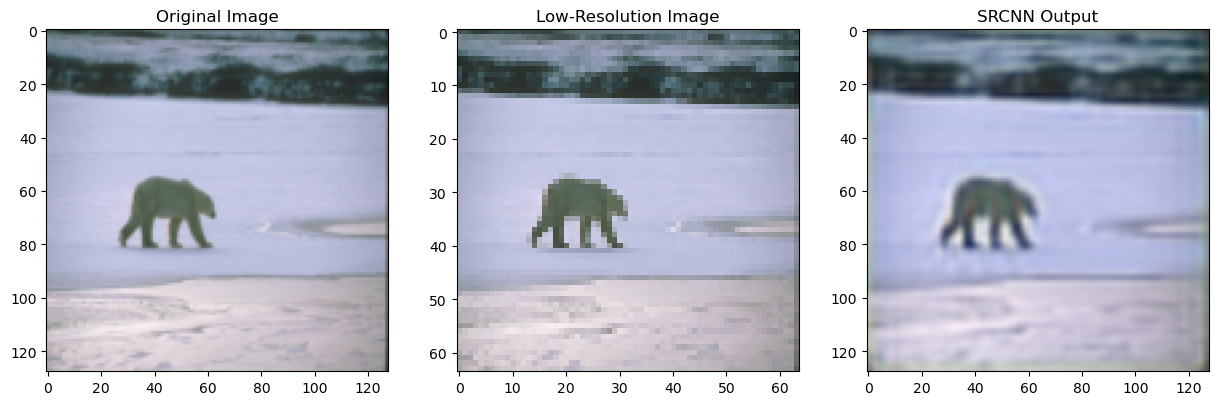

Epoch [31/100], Step [10/13], Loss: 0.0031
Validation - Epoch [31/100], SSIM: 0.7869, PSNR: 25.2848, MSE: 0.0027
Epoch [32/100], Step [10/13], Loss: 0.0022
Validation - Epoch [32/100], SSIM: 0.7877, PSNR: 26.1866, MSE: 0.0023
Epoch [33/100], Step [10/13], Loss: 0.0030
Validation - Epoch [33/100], SSIM: 0.7912, PSNR: 26.0919, MSE: 0.0023
Epoch [34/100], Step [10/13], Loss: 0.0028
Validation - Epoch [34/100], SSIM: 0.7940, PSNR: 26.3832, MSE: 0.0022
Epoch [35/100], Step [10/13], Loss: 0.0021
Validation - Epoch [35/100], SSIM: 0.7964, PSNR: 26.6363, MSE: 0.0021
Epoch [36/100], Step [10/13], Loss: 0.0019
Validation - Epoch [36/100], SSIM: 0.7981, PSNR: 26.6654, MSE: 0.0021
Epoch [37/100], Step [10/13], Loss: 0.0026
Validation - Epoch [37/100], SSIM: 0.8000, PSNR: 26.7068, MSE: 0.0021
Epoch [38/100], Step [10/13], Loss: 0.0018
Validation - Epoch [38/100], SSIM: 0.8021, PSNR: 26.8196, MSE: 0.0020
Epoch [39/100], Step [10/13], Loss: 0.0020
Validation - Epoch [39/100], SSIM: 0.8037, PSNR: 26.8

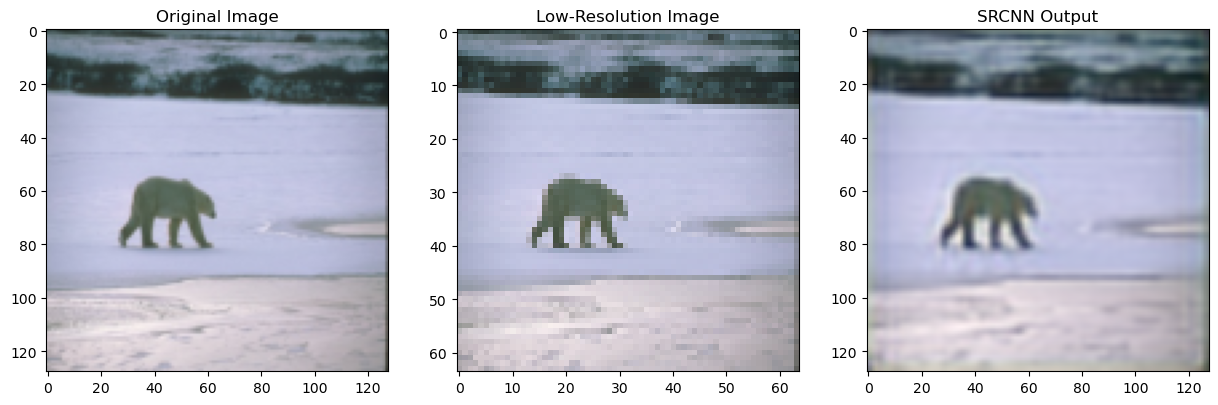

Epoch [41/100], Step [10/13], Loss: 0.0023
Validation - Epoch [41/100], SSIM: 0.8070, PSNR: 26.9820, MSE: 0.0019
Epoch [42/100], Step [10/13], Loss: 0.0019
Validation - Epoch [42/100], SSIM: 0.8084, PSNR: 26.8804, MSE: 0.0020
Epoch [43/100], Step [10/13], Loss: 0.0017
Validation - Epoch [43/100], SSIM: 0.8100, PSNR: 26.9336, MSE: 0.0019
Epoch [44/100], Step [10/13], Loss: 0.0019
Validation - Epoch [44/100], SSIM: 0.8115, PSNR: 27.1058, MSE: 0.0019
Epoch [45/100], Step [10/13], Loss: 0.0015
Validation - Epoch [45/100], SSIM: 0.8131, PSNR: 27.1152, MSE: 0.0019
Epoch [46/100], Step [10/13], Loss: 0.0018
Validation - Epoch [46/100], SSIM: 0.8142, PSNR: 27.1645, MSE: 0.0019
Epoch [47/100], Step [10/13], Loss: 0.0020
Validation - Epoch [47/100], SSIM: 0.8157, PSNR: 27.2281, MSE: 0.0018
Epoch [48/100], Step [10/13], Loss: 0.0022
Validation - Epoch [48/100], SSIM: 0.8172, PSNR: 27.2423, MSE: 0.0018
Epoch [49/100], Step [10/13], Loss: 0.0021
Validation - Epoch [49/100], SSIM: 0.8182, PSNR: 27.2

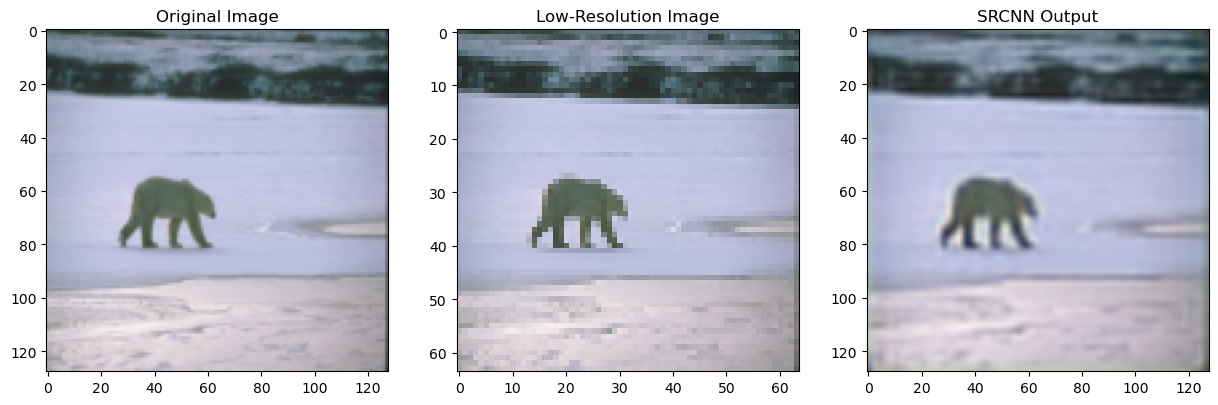

Epoch [51/100], Step [10/13], Loss: 0.0021
Validation - Epoch [51/100], SSIM: 0.8208, PSNR: 27.3167, MSE: 0.0018
Epoch [52/100], Step [10/13], Loss: 0.0015
Validation - Epoch [52/100], SSIM: 0.8217, PSNR: 26.6651, MSE: 0.0020
Epoch [53/100], Step [10/13], Loss: 0.0017
Validation - Epoch [53/100], SSIM: 0.8249, PSNR: 27.1027, MSE: 0.0018
Epoch [54/100], Step [10/13], Loss: 0.0018
Validation - Epoch [54/100], SSIM: 0.8270, PSNR: 27.0489, MSE: 0.0019
Epoch [55/100], Step [10/13], Loss: 0.0022
Validation - Epoch [55/100], SSIM: 0.8279, PSNR: 26.7258, MSE: 0.0020
Epoch [56/100], Step [10/13], Loss: 0.0015
Validation - Epoch [56/100], SSIM: 0.8293, PSNR: 27.2124, MSE: 0.0018
Epoch [57/100], Step [10/13], Loss: 0.0018
Validation - Epoch [57/100], SSIM: 0.8313, PSNR: 27.5521, MSE: 0.0017
Epoch [58/100], Step [10/13], Loss: 0.0018
Validation - Epoch [58/100], SSIM: 0.8320, PSNR: 27.3774, MSE: 0.0017
Epoch [59/100], Step [10/13], Loss: 0.0013
Validation - Epoch [59/100], SSIM: 0.8318, PSNR: 26.8

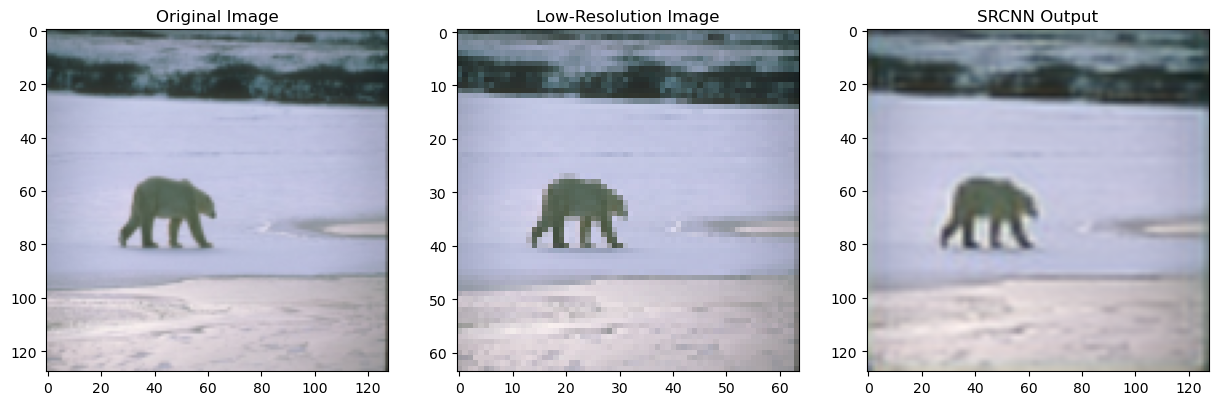

Epoch [61/100], Step [10/13], Loss: 0.0018
Validation - Epoch [61/100], SSIM: 0.8344, PSNR: 27.2430, MSE: 0.0018
Epoch [62/100], Step [10/13], Loss: 0.0014
Validation - Epoch [62/100], SSIM: 0.8358, PSNR: 27.5930, MSE: 0.0017
Epoch [63/100], Step [10/13], Loss: 0.0017
Validation - Epoch [63/100], SSIM: 0.8368, PSNR: 27.7077, MSE: 0.0016
Epoch [64/100], Step [10/13], Loss: 0.0015
Validation - Epoch [64/100], SSIM: 0.8372, PSNR: 27.1921, MSE: 0.0018
Epoch [65/100], Step [10/13], Loss: 0.0018
Validation - Epoch [65/100], SSIM: 0.8380, PSNR: 27.7078, MSE: 0.0016
Epoch [66/100], Step [10/13], Loss: 0.0015
Validation - Epoch [66/100], SSIM: 0.8391, PSNR: 27.7802, MSE: 0.0016
Epoch [67/100], Step [10/13], Loss: 0.0015
Validation - Epoch [67/100], SSIM: 0.8398, PSNR: 27.7990, MSE: 0.0016
Epoch [68/100], Step [10/13], Loss: 0.0016
Validation - Epoch [68/100], SSIM: 0.8403, PSNR: 27.7087, MSE: 0.0016
Epoch [69/100], Step [10/13], Loss: 0.0016
Validation - Epoch [69/100], SSIM: 0.8409, PSNR: 27.7

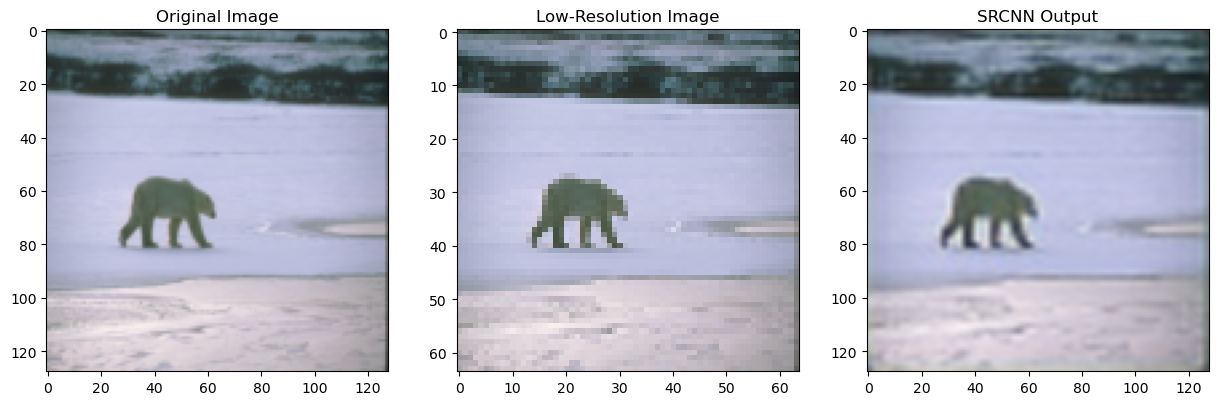

Epoch [71/100], Step [10/13], Loss: 0.0015
Validation - Epoch [71/100], SSIM: 0.8409, PSNR: 27.1463, MSE: 0.0018
Epoch [72/100], Step [10/13], Loss: 0.0016
Validation - Epoch [72/100], SSIM: 0.8406, PSNR: 26.3785, MSE: 0.0021
Epoch [73/100], Step [10/13], Loss: 0.0023
Validation - Epoch [73/100], SSIM: 0.8423, PSNR: 27.9094, MSE: 0.0016
Epoch [74/100], Step [10/13], Loss: 0.0019
Validation - Epoch [74/100], SSIM: 0.8428, PSNR: 27.8208, MSE: 0.0016
Epoch [75/100], Step [10/13], Loss: 0.0018
Validation - Epoch [75/100], SSIM: 0.8430, PSNR: 27.4813, MSE: 0.0017
Epoch [76/100], Step [10/13], Loss: 0.0016
Validation - Epoch [76/100], SSIM: 0.8438, PSNR: 27.7334, MSE: 0.0016
Epoch [77/100], Step [10/13], Loss: 0.0012
Validation - Epoch [77/100], SSIM: 0.8428, PSNR: 26.2680, MSE: 0.0021
Epoch [78/100], Step [10/13], Loss: 0.0016
Validation - Epoch [78/100], SSIM: 0.8448, PSNR: 27.9410, MSE: 0.0016
Epoch [79/100], Step [10/13], Loss: 0.0016
Validation - Epoch [79/100], SSIM: 0.8451, PSNR: 27.8

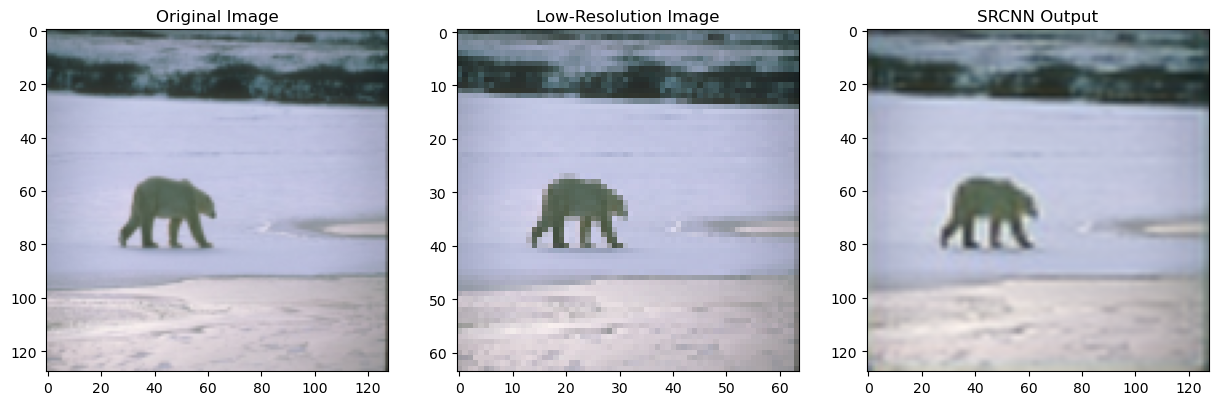

Epoch [81/100], Step [10/13], Loss: 0.0013
Validation - Epoch [81/100], SSIM: 0.8460, PSNR: 27.8881, MSE: 0.0016
Epoch [82/100], Step [10/13], Loss: 0.0017
Validation - Epoch [82/100], SSIM: 0.8463, PSNR: 28.0201, MSE: 0.0015
Epoch [83/100], Step [10/13], Loss: 0.0014
Validation - Epoch [83/100], SSIM: 0.8467, PSNR: 28.0372, MSE: 0.0015
Epoch [84/100], Step [10/13], Loss: 0.0016
Validation - Epoch [84/100], SSIM: 0.8470, PSNR: 28.0104, MSE: 0.0015
Epoch [85/100], Step [10/13], Loss: 0.0017
Validation - Epoch [85/100], SSIM: 0.8473, PSNR: 27.8468, MSE: 0.0016
Epoch [86/100], Step [10/13], Loss: 0.0016
Validation - Epoch [86/100], SSIM: 0.8469, PSNR: 27.4712, MSE: 0.0017
Epoch [87/100], Step [10/13], Loss: 0.0013
Validation - Epoch [87/100], SSIM: 0.8460, PSNR: 26.3662, MSE: 0.0021
Epoch [88/100], Step [10/13], Loss: 0.0019
Validation - Epoch [88/100], SSIM: 0.8465, PSNR: 27.2877, MSE: 0.0017
Epoch [89/100], Step [10/13], Loss: 0.0018
Validation - Epoch [89/100], SSIM: 0.8463, PSNR: 27.2

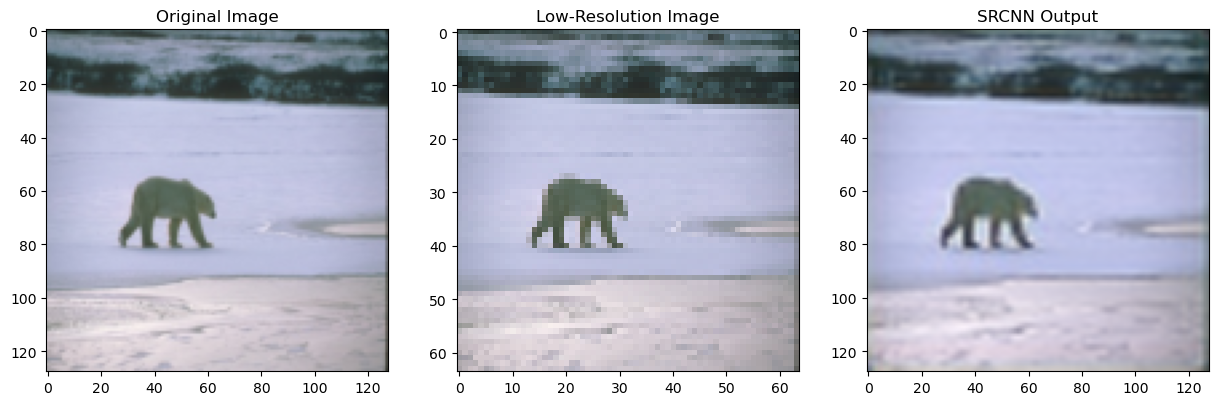

Epoch [91/100], Step [10/13], Loss: 0.0018
Validation - Epoch [91/100], SSIM: 0.8486, PSNR: 28.0851, MSE: 0.0015
Epoch [92/100], Step [10/13], Loss: 0.0012
Validation - Epoch [92/100], SSIM: 0.8486, PSNR: 27.9943, MSE: 0.0015
Epoch [93/100], Step [10/13], Loss: 0.0017
Validation - Epoch [93/100], SSIM: 0.8492, PSNR: 27.9766, MSE: 0.0015
Epoch [94/100], Step [10/13], Loss: 0.0015
Validation - Epoch [94/100], SSIM: 0.8496, PSNR: 28.1500, MSE: 0.0015
Epoch [95/100], Step [10/13], Loss: 0.0013
Validation - Epoch [95/100], SSIM: 0.8499, PSNR: 28.0919, MSE: 0.0015
Epoch [96/100], Step [10/13], Loss: 0.0018
Validation - Epoch [96/100], SSIM: 0.8478, PSNR: 25.9453, MSE: 0.0023
Epoch [97/100], Step [10/13], Loss: 0.0018
Validation - Epoch [97/100], SSIM: 0.8492, PSNR: 27.2860, MSE: 0.0017
Epoch [98/100], Step [10/13], Loss: 0.0016
Validation - Epoch [98/100], SSIM: 0.8486, PSNR: 26.6679, MSE: 0.0020
Epoch [99/100], Step [10/13], Loss: 0.0015
Validation - Epoch [99/100], SSIM: 0.8500, PSNR: 27.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Validation - Epoch [100/100], SSIM: 0.8504, PSNR: 27.8482, MSE: 0.0016


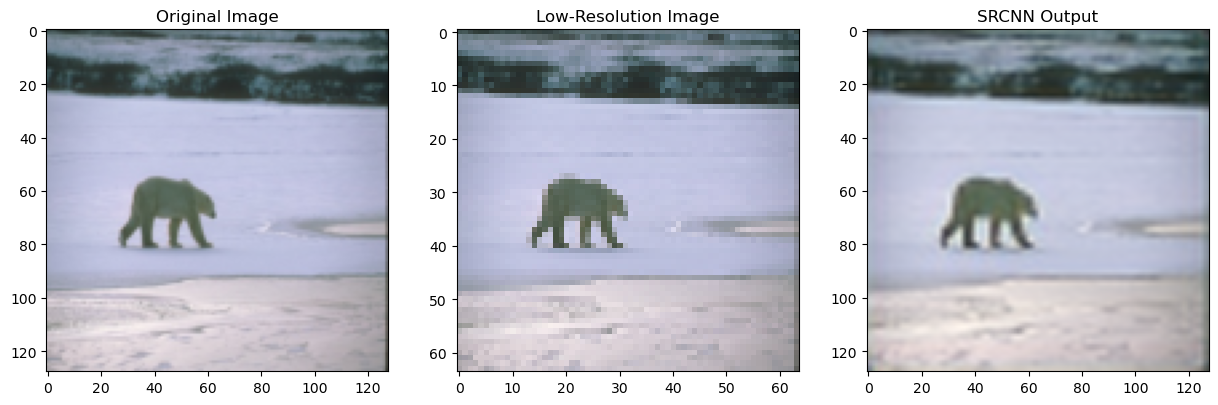

In [9]:
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def visualize_progress(model, dataloader):
    model.eval()
    with torch.no_grad():  # No gradients: During evaluation or inference, we don't need to update the model, so calculating gradients is unnecessary and takes extra memory and computation.
        for i, data in enumerate(dataloader):
            inputs = data.to(device)
            inputs_low_res = F.interpolate(inputs, scale_factor=0.5, mode='bicubic', align_corners=False)
            outputs = model(inputs_low_res)
            outputs_upsampled = F.interpolate(outputs, size=inputs.shape[2:], mode='bicubic', align_corners=False) # inputs (batch_size, channels, height, width) make the size of the target image as the input

            # Display the input, low-res, and output images
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(inputs[0].cpu().permute(1, 2, 0))
            axs[0].set_title('Original Image')
            axs[1].imshow(inputs_low_res[0].cpu().permute(1, 2, 0))
            axs[1].set_title('Low-Resolution Image')
            axs[2].imshow(outputs_upsampled[0].cpu().permute(1, 2, 0))
            axs[2].set_title('SRCNN Output')
            plt.show()

            # Only visualize one batch for simplicity
            break

for epoch in range(num_epochs):
    model.train()
    for i, data in enumerate(train_loader):
        inputs = data.to(device)
        inputs_low_res = F.interpolate(inputs, scale_factor=0.5, mode='bicubic', align_corners=False)
        outputs = model(inputs_low_res)
        outputs_upsampled = F.interpolate(outputs, size=inputs.shape[2:], mode='bicubic', align_corners=False)
        loss = criterion(outputs_upsampled, inputs)

        optimizer.zero_grad() # resetting the gradients of all the model's parameters to zero. # Resetting: We need to reset (clear) the gradients to zero before computing the new gradients for the next batch.
        loss.backward() # Calculates the gradients of the loss with respect to the model's parameters # understanding how much each parameter contributed to the error.
        optimizer.step() # Updates the model's parameters using the gradients calculated 

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}') # 13 batches of data.
    
    # Validation
    model.eval()
    ssim_total, psnr_total, mse_total = 0, 0, 0
    with torch.no_grad():
        for data in val_loader:
            inputs = data.to(device)
            inputs_low_res = F.interpolate(inputs, scale_factor=0.5, mode='bicubic', align_corners=False)
            outputs = model(inputs_low_res)
            outputs_upsampled = F.interpolate(outputs, size=inputs.shape[2:], mode='bicubic', align_corners=False)
            ssim_val, psnr_val, mse_val = calculate_metrics(outputs_upsampled, inputs)
            ssim_total += ssim_val
            psnr_total += psnr_val
            mse_total += mse_val

    print(f'Validation - Epoch [{epoch+1}/{num_epochs}], SSIM: {ssim_total/len(val_loader):.4f}, PSNR: {psnr_total/len(val_loader):.4f}, MSE: {mse_total/len(val_loader):.4f}')
    
    # Visualize progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        visualize_progress(model, test_loader)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


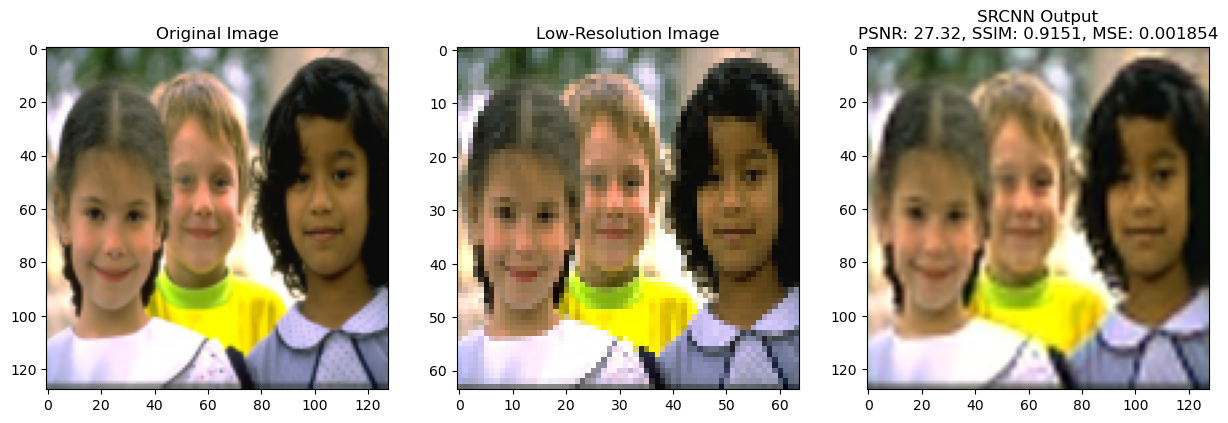

In [37]:
def visualize_one_random_image(model, dataloader):
    model.eval()
    with torch.no_grad():
        data_iter = iter(dataloader)
        data = next(data_iter)
        inputs = data.to(device)
        inputs_low_res = F.interpolate(inputs, scale_factor=0.5, mode='bicubic', align_corners=False)
        outputs = model(inputs_low_res)
        outputs_upsampled = F.interpolate(outputs, size=inputs.shape[2:], mode='bicubic', align_corners=False)

        # Calculate metrics
        ssim_val, psnr_val, mse_val = calculate_metrics(outputs_upsampled, inputs)

        # Display the input, low-res, and output images
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(inputs[0].cpu().permute(1, 2, 0))
        axs[0].set_title('Original Image')
        axs[1].imshow(inputs_low_res[0].cpu().permute(1, 2, 0))
        axs[1].set_title('Low-Resolution Image')
        axs[2].imshow(outputs_upsampled[0].cpu().permute(1, 2, 0))
        axs[2].set_title(f'SRCNN Output\nPSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}, MSE: {mse_val:.6f}')
        plt.show()

visualize_one_random_image(model, DataLoader(test_dataset, batch_size=1, shuffle=True))
